# Informe Accidentalidad - Barranquilla

### Descargamos e importamos instancias necesarias

In [ ]:
%pip install sodapy
%pip install geopy
%pip install folium
import pandas as pd
from sodapy import Socrata
import requests
from geopy.geocoders import Nominatim
import folium
from IPython.display import IFrame
import matplotlib.pyplot as plt

# Configuración de no truncar visualización de los DF.
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

### Obtenemos los datos de: https://www.datos.gov.co/Transporte/Accidentalidad-Barranquilla-detalle-de-Veh-culos/nfa3-wgxy/about_data

In [2]:
client = Socrata("www.datos.gov.co", None)
results = client.get("nfa3-wgxy", limit=50000)
results_df = pd.DataFrame.from_records(results)

### Obetenemos un poco de información acerca de nuestros datos generales de accidentalidad en la ciudad de Barranquilla.

In [77]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43394 entries, 0 to 43393
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   a_o_accidente                  43394 non-null  object
 1   mes_accidente                  43394 non-null  object
 2   clase_accidente                43394 non-null  object
 3   servicio_vehiculo_accidentado  43394 non-null  object
 4   clase_vehiculo_accidentado     43394 non-null  object
 5   cantidad_vehiculos             43394 non-null  object
 6   direccion_accidente            43394 non-null  object
dtypes: object(7)
memory usage: 2.3+ MB


In [78]:
results_df.describe()

,a_o_accidente,mes_accidente,clase_accidente,servicio_vehiculo_accidentado,clase_vehiculo_accidentado,cantidad_vehiculos,direccion_accidente
count,43394,43394,43394,43394,43394,43394,43394
unique,6,12,6,7,35,7,14588
top,2018,2,Choque,PARTICULAR,AUTOMOVIL,1,CL 110 CR 9G
freq,10606,4173,41738,26430,18917,38949,110


#### Aquí podemos encontrar datos interesantes como por ejemplo:

1. El año en que se presentarón mas accidentes fue 2018, con un total de 10606.
2. El mes donde generalmente se presentan mas accidentes es febrero, con un total de 4173.
3. La ubicación de la ciudad con mas accidentes desde 2028 hasta agosto de 2023 fue CL 110 CR 9G.

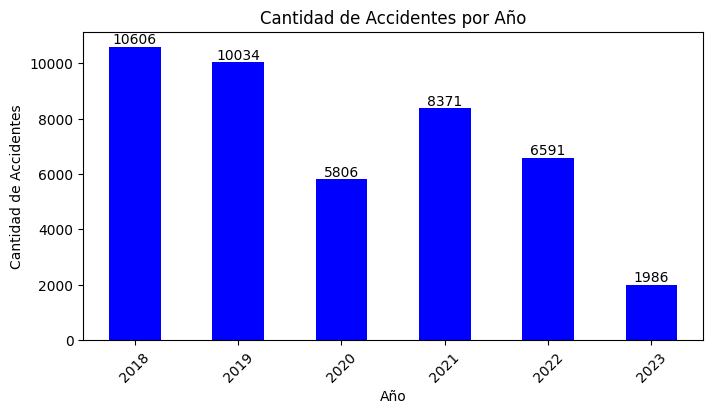

In [99]:
accidentes_por_año = results_df['a_o_accidente'].value_counts().sort_index()

plt.figure(figsize=(8, 4))
bar_one = accidentes_por_año.plot.bar(x=accidentes_por_año.index, y=accidentes_por_año.values, color='blue')
plt.title('Cantidad de Accidentes por Año')
plt.xlabel('Año')
plt.ylabel('Cantidad de Accidentes')
plt.xticks(rotation=45)
for i, valor in enumerate(accidentes_por_año.values):
    bar_one.text(i, valor + 0.2, str(valor), ha='center', va='bottom')
plt.show()

##### Con este grafico podemos ver que el año en el que se presentaron mas accidentes fue en 2018. Finalmente, hay que tener en cuenta que nuestro dataset tiene un limite de datos en 2023 hasta octubre. Por lo tanto, no llegamos a tener mas de 2000 accidentes desde enero hasta agosto.

##### Ahora bien, queremos ver el comportamiento de todos los años registrados desde enero hasta agosto, para poder tener una comparación equitativa y ver el comportamiento grafico hasta esa fecha.

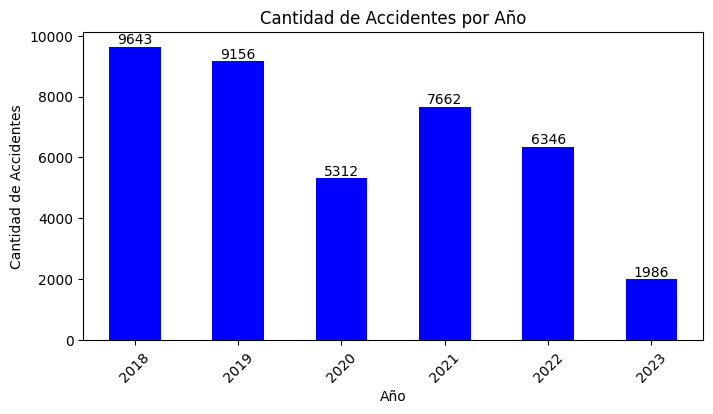

In [103]:
accidentes_enero_agosto = results_df[(results_df['mes_accidente'] >= '1') & (results_df['mes_accidente'] <= '8')]

accidentes_por_año_enero_agosto = accidentes_enero_agosto['a_o_accidente'].value_counts().sort_index()

plt.figure(figsize=(8, 4))
bar_two = accidentes_por_año_enero_agosto.plot.bar(x=accidentes_por_año_enero_agosto.index, y=accidentes_por_año_enero_agosto.values, color='blue')
plt.title('Cantidad de Accidentes por Año')
plt.xlabel('Año')
plt.ylabel('Cantidad de Accidentes')
plt.xticks(rotation=45)
for i, valor in enumerate(accidentes_por_año_enero_agosto.values):
    bar_two.text(i, valor + 0.2, str(valor), ha='center', va='bottom')
plt.show()

### Ahora, a partir de aquí, queremos hacer un analisis de estos datos de accidentalidad en este año 2023.

In [73]:
df_2023 = results_df[results_df["a_o_accidente"] == "2023"]

In [79]:
df_2023.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1986 entries, 41408 to 43393
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   a_o_accidente                  1986 non-null   object
 1   mes_accidente                  1986 non-null   object
 2   clase_accidente                1986 non-null   object
 3   servicio_vehiculo_accidentado  1986 non-null   object
 4   clase_vehiculo_accidentado     1986 non-null   object
 5   cantidad_vehiculos             1986 non-null   object
 6   direccion_accidente            1986 non-null   object
dtypes: object(7)
memory usage: 124.1+ KB


In [80]:
df_2023.describe()

,a_o_accidente,mes_accidente,clase_accidente,servicio_vehiculo_accidentado,clase_vehiculo_accidentado,cantidad_vehiculos,direccion_accidente
count,1986,1986,1986,1986,1986,1986,1986
unique,1,8,6,5,16,3,1045
top,2023,2,Choque,PARTICULAR,MOTOCICLETA,1,CALLE 110 CARRERA 43
freq,1986,281,1799,1355,770,1851,11


In [69]:
# Función para obtener la latitud y longitud de una dirección con Geopy
def obtener_latitud_longitud_geopy(direccion):
    geolocator = Nominatim(user_agent="my_geocoder")
    try:
        location = geolocator.geocode(direccion, timeout=10)
    except Exception as e:
        print(f"Error en la solicitud Geopy: {e}")
        location = None

    if location:
        latitud = location.latitude
        longitud = location.longitude
        return latitud, longitud
    else:
        return None, None


# Función para obtener la latitud y longitud de una dirección con Azure Maps
def obtener_latitud_longitud_azure(direccion):
    
    url = f"https://atlas.microsoft.com/search/address/json?api-version=1.0&subscription-key={'API_KEY'}&query={direccion}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        if data.get('results'):
            location = data['results'][0]['position']
            return location['lat'], location['lon']

    # Devuelve valores predeterminados si no se encuentra la ubicación
    return None, None


def obtener_latitud_longitud(direccion):
    latitud, longitud = obtener_latitud_longitud_geopy(direccion)

    if latitud is None or longitud is None:
        latitud, longitud = obtener_latitud_longitud_azure(direccion)

    return latitud, longitud

In [12]:
latlong = []
# Iterar sobre las direcciones y obtener latitud y longitud
for direccion in df_2023['direccion_accidente']:
    latitud, longitud = obtener_latitud_longitud_azure(f"{direccion}, Barranquilla, Atlántico, Colombia")
    latlong.append({'Latitud': latitud, 'Longitud': longitud})

# Crear un DF con las latitudes y longitudes
latlong_df = pd.DataFrame(latlong)
# Guardar el DF en un archivo CSV
latlong_df.to_csv('accidentes_bquilla_2023_azure.csv')

In [65]:
# Leer el archivo CSV con las latitudes y longitudes
df_clean_accidentes_2023 = pd.read_csv("accidentes_bquilla_2023_azure.csv")

In [66]:
df_clean_accidentes_2023.dropna(inplace=True)
print(f"Dimensiones del DF: {df_clean_accidentes_2023.shape}")

In [68]:
# Crea un objeto gmplot centrado en las coordenadas promedio
barranquilla_map = folium.Map(location=[df_clean_accidentes_2023['Latitud'].iloc[0], df_clean_accidentes_2023['Longitud'].iloc[0]], zoom_start=13)

# Agrega marcadores para cada accidente en el DataFrame
for index, row in df_clean_accidentes_2023.iterrows():
    latitud = row['Latitud']
    longitud = row['Longitud']
    folium.Marker(location=[latitud, longitud]).add_to(barranquilla_map)

# Mostar el mapa
barranquilla_map